## Ajustando un sistema lente simulado

Objetivos:

1. Leer una imagen fits
2. Configurar los modulos de datos, lensmodel, lightmodel (lente y fuente)
3. Hacer una optimizacion utilizando PSO
4. Optimizar utilizando un PSO y MCMC

In [1]:
# some standard python imports #
import numpy as np
import copy
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#lenstronomy imports
from lenstronomy.LensModel.lens_model import LensModel
import lenstronomy.Util.param_util as param_util
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.Data.psf import PSF
from lenstronomy.ImSim.image_model import ImageModel
import lenstronomy.Util.image_util as image_util
import lenstronomy.Util.simulation_util as sim_util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF

### Importamos la imagen fits del sistema que vamos a ajustar:

/home/karina/miniconda3/envs/LENS/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  150                                                  
NAXIS2  =                  150                                                  
DELTAPIX=                 0.03                                                  
NUMPIX  =                  150                                                  
NAMEOBJ = 'sistema1'                                                            
EXP_TIME=                 1000                                                  
FHWM_PSF=                 0.15                                                  

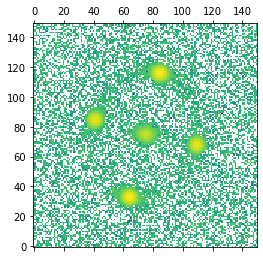

In [27]:
path = '/home/karina/Dropbox/Clase_lens/Clase6/'

hdul = fits.open(path+'fig1.fits')
data=hdul[0].data # or hdul[1]
header = hdul[0].header

plt.matshow(np.log10(data),origin='lower')
header

### Modulo Data

Vamos a establecer el modulo Data con las caracteriticas especificas referentes a nuestros datos:

In [4]:
# data specifics
exp_time = header['EXP_TIME']
numPix = len(data)
deltaPix = header['DELTAPIX']
transform_pix2angle = np.array([[1, 0], [0, 1]]) * deltaPix

fwhm = header['FHWM_PSF']
fwhm

0.15

Solo nos falta definir el background, **pero como lo hacemos?**

( esto era una de las tareas extras de la clase 1 ;) )

In [6]:
def background_rms_image(cb,image):
    xg,yg = np.shape(image)
    cut0  = image[0:cb,0:cb]
    cut1  = image[xg-cb:xg,0:cb]
    cut2  = image[0:cb,yg-cb:yg]
    cut3  = image[xg-cb:xg,yg-cb:yg]
    std   = np.std([cut0,cut1,cut2,cut3])
    return std

In [7]:
background_rms = background_rms_image(10,data)
print(background_rms)

0.05138837993270708


Definimos posiciones de la galaxia lente y las imagenes y la clase Data:

In [30]:
x_gl,y_gl = 0,0
ra_at_xy_0, dec_at_xy_0 = x_gl-(deltaPix)*(numPix/2.),y_gl-(deltaPix)*(numPix/2.)

kwargs_data = {'background_rms': background_rms, 'exposure_time':exp_time, 'transform_pix2angle': transform_pix2angle,
               'image_data': data,'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,}
data_class = ImageData(**kwargs_data)

galx,galy = data_class.map_pix2coord(x=76,y=76)
Imx,Imy =data_class.map_pix2coord(x=[86,42,65,110],y=[117,86,34,69])

#galx,galy = data_class.map_pix2coord(x=76,y=74)
#Imx,Imy =data_class.map_pix2coord(x=[99,41,35,90],y=[119,94,74,54])

x_image,y_image = Imx - galx, Imy - galy
x_image,y_image

(array([ 0.3 , -1.02, -0.33,  1.02]), array([ 1.23,  0.3 , -1.26, -0.21]))

In [9]:
# PSF specification
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix}
psf_class = PSF(**kwargs_psf)

## Configuramos el modelo a ajustar

In [10]:
#septup model
lens_model_list = ['SIE']
source_model_list = ['SERSIC']
lens_light_model_list = ['SERSIC_ELLIPSE']
point_source_list = ['LENSED_POSITION']

#point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])

kwargs_model = {'lens_model_list': lens_model_list,'source_light_model_list': source_model_list,'lens_light_model_list': lens_light_model_list,'point_source_model_list': point_source_list}

kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

#### Definimos los parametros iniciales de cada modelo:

In [11]:
# initial guess of non-linear parameters, we chose different starting parameters than the truth #
kwargs_lens_init = [{'theta_E': 1.2, 'e1': 0, 'e2': 0, 'center_x': x_gl, 'center_y':y_gl}]
kwargs_source_init = [{'R_sersic': 0.1, 'n_sersic': 1., 'center_x': 0, 'center_y': 0}]
kwargs_lens_light_init = [{'R_sersic': 0.1, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': x_gl, 'center_y': y_gl}]
kwargs_ps_init = [{'ra_image': x_image, 'dec_image': y_image}]


# initial spread in parameter estimation #
kwargs_lens_sigma = [{'theta_E': 0.3, 'e1': 0.2, 'e2': 0.2,  'center_x': 0.1, 'center_y': 0.1}]
kwargs_source_sigma = [{'R_sersic': 0.1, 'n_sersic': .5, 'center_x': .1, 'center_y': 0.1}]
kwargs_lens_light_sigma = [{'R_sersic': 0.1, 'n_sersic': 0.2, 'e1': 0.1, 'e2': 0.1, 'center_x': .1, 'center_y': 0.1}]
kwargs_ps_sigma = [{'ra_image': [0.02] * 4, 'dec_image': [0.02] * 4}]

# list fixed parameters #
kwargs_fixed_lens = [{}]
kwargs_fixed_source = [{}]
kwargs_fixed_lens_light = [{}]
kwargs_fixed_ps = [{}]

# hard bound lower limit in parameter space #
kwargs_lower_lens = [{'theta_E': 0.5, 'e1': -0.5, 'e2': -0.5, 'center_x': -5., 'center_y': -5}]
kwargs_lower_source = [{'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -5, 'center_y': -5}]
kwargs_lower_lens_light = [{'R_sersic': 0.001, 'n_sersic': 0.5, 'e1': -0.5, 'e2': -0.5, 'center_x': -5, 'center_y': -5}]
kwargs_lower_ps = [{'ra_image': -5 * np.ones_like(x_image), 'dec_image': -5 * np.ones_like(y_image)}]

# hard bound upper limit in parameter space #
kwargs_upper_lens = [{'theta_E': 3, 'e1': 0.5, 'e2': 0.5, 'center_x': 5., 'center_y': 5}]
kwargs_upper_source = [{'R_sersic': 10, 'n_sersic': 5., 'center_x': 5, 'center_y': 5}]
kwargs_upper_lens_light = [{'R_sersic': 10, 'n_sersic': 5., 'e1': 0.5, 'e2': 0.5, 'center_x': 5, 'center_y': 5}]
kwargs_upper_ps = [{'ra_image': 5 * np.ones_like(x_image), 'dec_image': 5 * np.ones_like(y_image)}]


#### Se define kwargs_param

In [12]:
lens_params = [kwargs_lens_init, kwargs_lens_sigma, kwargs_fixed_lens, kwargs_lower_lens, kwargs_upper_lens]
source_params = [kwargs_source_init, kwargs_source_sigma, kwargs_fixed_source , kwargs_lower_source, kwargs_upper_source]
lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, kwargs_fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]
ps_params = [kwargs_ps_init, kwargs_ps_sigma, kwargs_fixed_ps, kwargs_lower_ps, kwargs_upper_ps]

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params,
                'point_source_model': ps_params}

1. Se debe configurar un kwargs para contrenir parametros, sino se deja vacio
2. Se debe configurar la clase likelihood, la cual realiza el calculo de diferentes probabilidades:

- Puede evaluar la probabilidad de obtener imagenes
- La posición de las imagenes.
- La probabilidad de retrazo temporal.

Para más detalles https://lenstronomy.readthedocs.io/en/latest/lenstronomy.Sampling.html

In [13]:
kwargs_constraints = {'joint_source_with_point_source': [[0, 0]], 'num_point_source_list': [4]} 
kwargs_likelihood = {'check_bounds': True}

#aqui se definen los set de datos en cojuntos [data+psf+numerics] 
image_band = [kwargs_data, kwargs_psf, kwargs_numerics]
image_band_list = [image_band]
kwargs_data_joint = {'multi_band_list': image_band_list, 'multi_band_type': 'multi-linear'}

## Optimizacion usando PSO:
### Particle Swarm Optimization o en espanol: Optimizacion por enjambre de particulas

En un principio el algoritmo se utilizaba para modelos de conductas sociales como el movimiento de una bandada de aves o un cardumen de peces. Posteriormente el algoritmo se simplificó y se comprobó que era adecuado para problemas de optimización.

PSO permite optimizar un problema a partir de una población de "partículas", moviendo éstas por todo el espacio de búsqueda según reglas matemáticas que tienen en cuenta la posición y la velocidad de las partículas.

El fundamento teórico de esto es hacer que la nube de partículas converja rápidamente hacia las mejores soluciones.

Para ver las opciones de lenstronomy: https://lenstronomy.readthedocs.io/en/latest/lenstronomy.Sampling.html?highlight=pso#lenstronomy.Sampling.sampler.Sampler.pso

In [14]:
from lenstronomy.Workflow.fitting_sequence import FittingSequence

fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [['PSO', {'n_particles': 50, 'n_iterations': 100}]]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()


Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-0.9539094254999255 reduced X^2 of best position
-10718.603259629914 logL
22473 effective number of data points
[{'theta_E': 1.1990914266582189, 'e1': 0.24341391500993267, 'e2': -0.1272648833628989, 'center_x': -0.006918314481772898, 'center_y': -0.004757495072802482}] lens result
[{'amp': 1, 'R_sersic': 0.11104063724036828, 'n_sersic': 2.0425385874093984, 'center_x': -0.012910729829194625, 'center_y': -0.023552842521304893}] source result
[{'amp': 1, 'R_sersic': 0.06974440339751835, 'n_sersic': 2.1633049020648785, 'e1': 0.24067481521347628, 'e2': -0.06807897799188975, 'center_x': 0.002727966906082047, 'center_y': -0.002384406868905632}] lens light result
[{'ra_image': array([ 0.28943294, -1.01511823, -0.33040652,  1.02510061]), 'dec_image': array([ 1.22861199,  0.29612512, -1.26305471, -0.21439439]), 'point_amp': [1, 1, 1, 1]}] point source result
{} special param result
200.87230682373047 time used 

In [15]:
kwargs_result = fitting_seq.best_fit()
kwargs_result

{'kwargs_lens': [{'theta_E': 1.1990914266582189,
   'e1': 0.24341391500993267,
   'e2': -0.1272648833628989,
   'center_x': -0.006918314481772898,
   'center_y': -0.004757495072802482}],
 'kwargs_source': [{'amp': 1,
   'R_sersic': 0.11104063724036828,
   'n_sersic': 2.0425385874093984,
   'center_x': -0.012910729829194625,
   'center_y': -0.023552842521304893}],
 'kwargs_lens_light': [{'amp': 1,
   'R_sersic': 0.06974440339751835,
   'n_sersic': 2.1633049020648785,
   'e1': 0.24067481521347628,
   'e2': -0.06807897799188975,
   'center_x': 0.002727966906082047,
   'center_y': -0.002384406868905632}],
 'kwargs_ps': [{'ra_image': array([ 0.28943294, -1.01511823, -0.33040652,  1.02510061]),
   'dec_image': array([ 1.22861199,  0.29612512, -1.26305471, -0.21439439]),
   'point_amp': [1, 1, 1, 1]}],
 'kwargs_special': {},
 'kwargs_extinction': []}

## Modulo para graficar los resultados 



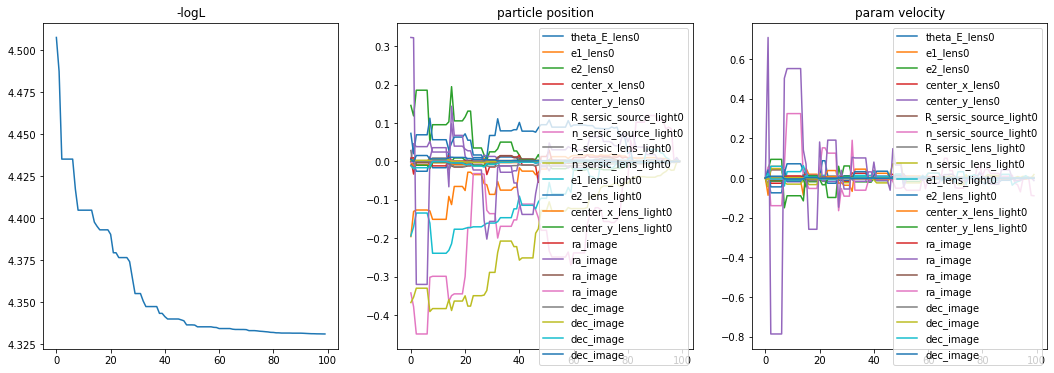

<Figure size 432x288 with 0 Axes>

In [16]:
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Plots import chain_plot

param_class = fitting_seq.param_class
#print(param_class.num_param())
#print(chain_list)

for i in range(len(chain_list)):
    chain_plot.plot_chain_list(chain_list, i)


-0.9527647341893256 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.9527647341893256


/home/karina/miniconda3/envs/LENS/lib/python3.7/site-packages/lenstronomy/Plots/model_band_plot.py:55: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gist_heat"))
  cmap.set_bad(color='k', alpha=1.)
/home/karina/miniconda3/envs/LENS/lib/python3.7/site-packages/lenstronomy/Plots/model_band_plot.py:56: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gist_heat"))
  cmap.set_under('k')
/home/karina/miniconda3/envs/LENS/lib/python3.7/site-packages/lenstronomy/Plots/model_band_plot.py:86: RuntimeWarning: invalid value encountered in log10
  

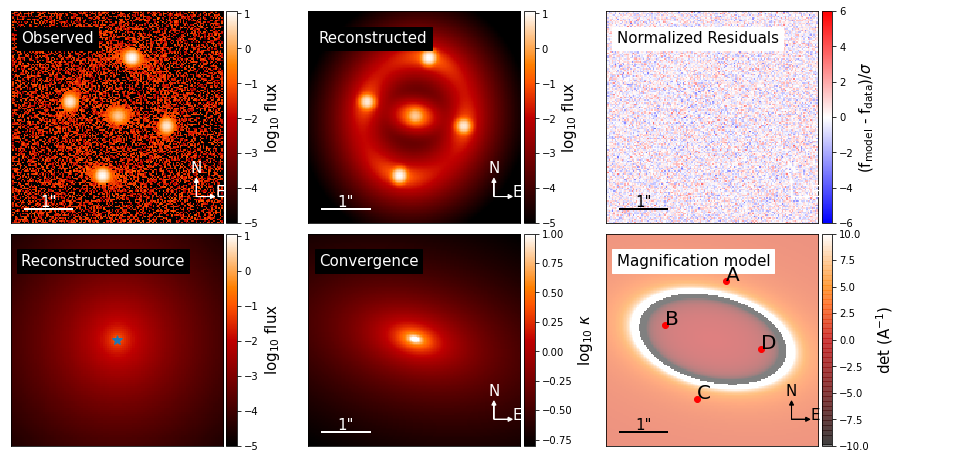

In [17]:
modelPlot = ModelPlot([[kwargs_data, kwargs_psf, kwargs_numerics]], kwargs_model, kwargs_result, arrow_size=0.02, 
                      cmap_string="gist_heat")

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0,0])
modelPlot.model_plot(ax=axes[0,1])
modelPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6)
modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
modelPlot.convergence_plot(ax=axes[1, 1], v_max=1)
modelPlot.magnification_plot(ax=axes[1, 2])
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

Graficando la descomposicion del Sistema:

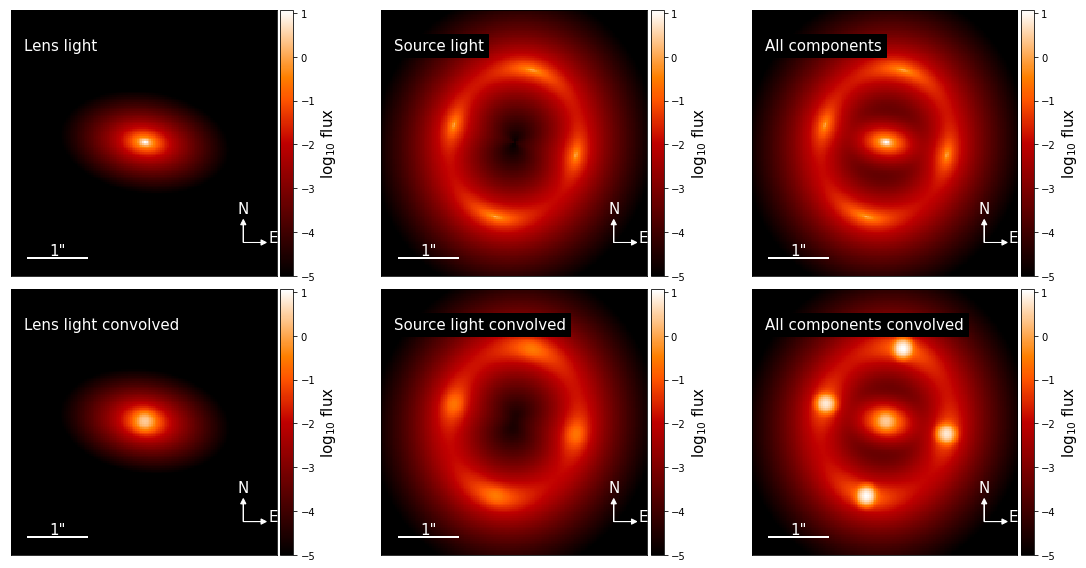

In [18]:
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.decomposition_plot(ax=axes[0,0], text='Lens light', lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,0], text='Lens light convolved', lens_light_add=True)
modelPlot.decomposition_plot(ax=axes[0,1], text='Source light', source_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,1], text='Source light convolved', source_add=True)
modelPlot.decomposition_plot(ax=axes[0,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

## Optimizacion usando PSO y MCMC:
### MCMC: Markov chain Monte Carlo

Los métodos de MCMC crean muestras a partir de una variable aleatoria continua, con densidad de probabilidad proporcional a una función conocida. Estas muestras se pueden utilizar para evaluar una integral sobre esa variable, como su valor esperado o varianza.

En la práctica, generalmente se desarrolla un conjunto de cadenas, partiendo de un conjunto de puntos elegidos arbitrariamente y suficientemente distantes entre sí. Estas cadenas son procesos estocásticos de "caminantes" (Walkers) que se mueven aleatoriamente según un algoritmo que busca lugares con una contribución razonablemente alta a la integral para pasar a la siguiente, asignándoles mayores probabilidades.

En lenstronomy 
https://lenstronomy.readthedocs.io/en/latest/lenstronomy.Workflow.html?highlight=mcmc#lenstronomy.Workflow.fitting_sequence.FittingSequence.mcmc

In [19]:
fitting_kwargs_list = [['PSO', {'n_particles': 50, 'n_iterations': 100}],
                       ['MCMC', {'n_burn': 10, 'n_run': 10, 'walkerRatio': 4}]]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-0.9531841595734244 reduced X^2 of best position
-10710.453809046783 logL
22473 effective number of data points
[{'theta_E': 1.1999350522184102, 'e1': 0.24149278945931227, 'e2': -0.12631477703759428, 'center_x': -0.008090100196490067, 'center_y': -0.001979642088791041}] lens result
[{'amp': 1, 'R_sersic': 0.10165592936795838, 'n_sersic': 1.969496477834572, 'center_x': -0.013021151104134751, 'center_y': -0.021592962137367874}] source result
[{'amp': 1, 'R_sersic': 0.0807312623615137, 'n_sersic': 2.169228604504035, 'e1': 0.24436250463313375, 'e2': -0.07776840742322073, 'center_x': 0.0012326266388810849, 'center_y': -0.0006352136495096857}] lens light result
[{'ra_image': array([ 0.28930269, -1.01499458, -0.33057887,  1.02518652]), 'dec_image': array([ 1.22863467,  0.29592904, -1.26307533, -0.21447479]), 'point_amp': [1, 1, 1, 1]}] point source result
{} special param result
205.57570576667786 time used 

/home/karina/miniconda3/envs/LENS/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Computing the MCMC...
Number of walkers =  84
Burn-in iterations:  10
Sampling iterations (in current run): 20
45.52794814109802 time taken for MCMC sampling


(21, ['theta_E_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'R_sersic_source_light0', 'n_sersic_source_light0', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'ra_image', 'ra_image', 'ra_image', 'ra_image', 'dec_image', 'dec_image', 'dec_image', 'dec_image'])
2


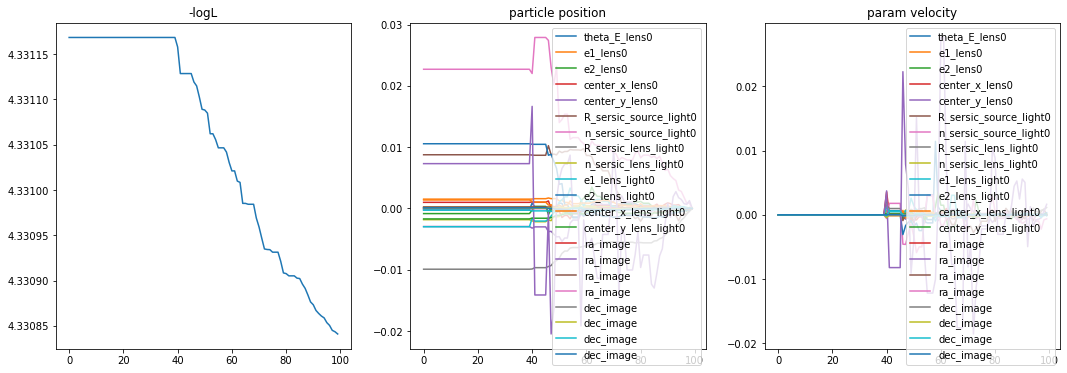

<Figure size 432x288 with 0 Axes>

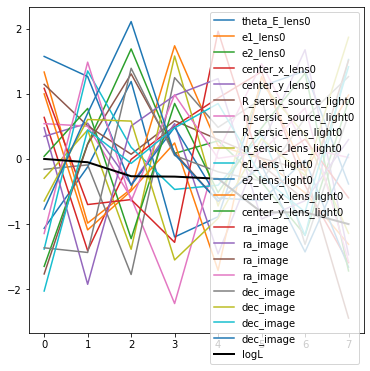

In [20]:
param_class = fitting_seq.param_class
print(param_class.num_param())
print(len(chain_list))

for i in range(len(chain_list)):
    chain_plot.plot_chain_list(chain_list, i)

In [21]:
len(chain_list)

2

-1.0589684313013548 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  1.0589684313013548


/home/karina/miniconda3/envs/LENS/lib/python3.7/site-packages/lenstronomy/Plots/model_band_plot.py:55: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gist_heat"))
  cmap.set_bad(color='k', alpha=1.)
/home/karina/miniconda3/envs/LENS/lib/python3.7/site-packages/lenstronomy/Plots/model_band_plot.py:56: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gist_heat"))
  cmap.set_under('k')
/home/karina/miniconda3/envs/LENS/lib/python3.7/site-packages/lenstronomy/Plots/model_band_plot.py:86: RuntimeWarning: invalid value encountered in log10
  

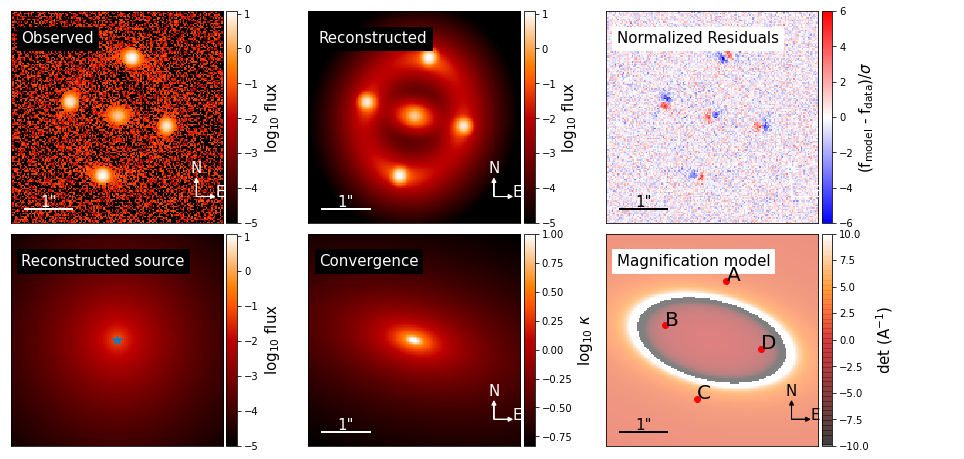

In [22]:
modelPlot = ModelPlot([[kwargs_data, kwargs_psf, kwargs_numerics]], kwargs_model, kwargs_result, arrow_size=0.02, 
                      cmap_string="gist_heat")

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0,0])
modelPlot.model_plot(ax=axes[0,1])
modelPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6)
modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
modelPlot.convergence_plot(ax=axes[1, 1], v_max=1)
modelPlot.magnification_plot(ax=axes[1, 2])
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

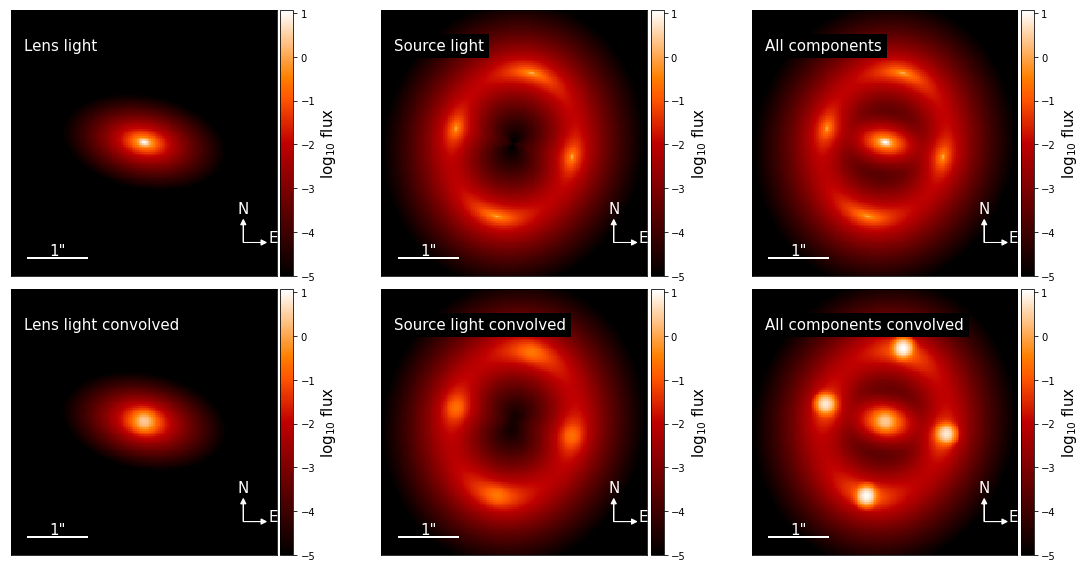

In [23]:
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.decomposition_plot(ax=axes[0,0], text='Lens light', lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,0], text='Lens light convolved', lens_light_add=True)
modelPlot.decomposition_plot(ax=axes[0,1], text='Source light', source_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,1], text='Source light convolved', source_add=True)
modelPlot.decomposition_plot(ax=axes[0,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

number of non-linear parameters in the MCMC process:  21
parameters in order:  ['theta_E_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'R_sersic_source_light0', 'n_sersic_source_light0', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'ra_image', 'ra_image', 'ra_image', 'ra_image', 'dec_image', 'dec_image', 'dec_image', 'dec_image']
number of evaluations in the MCMC process:  840


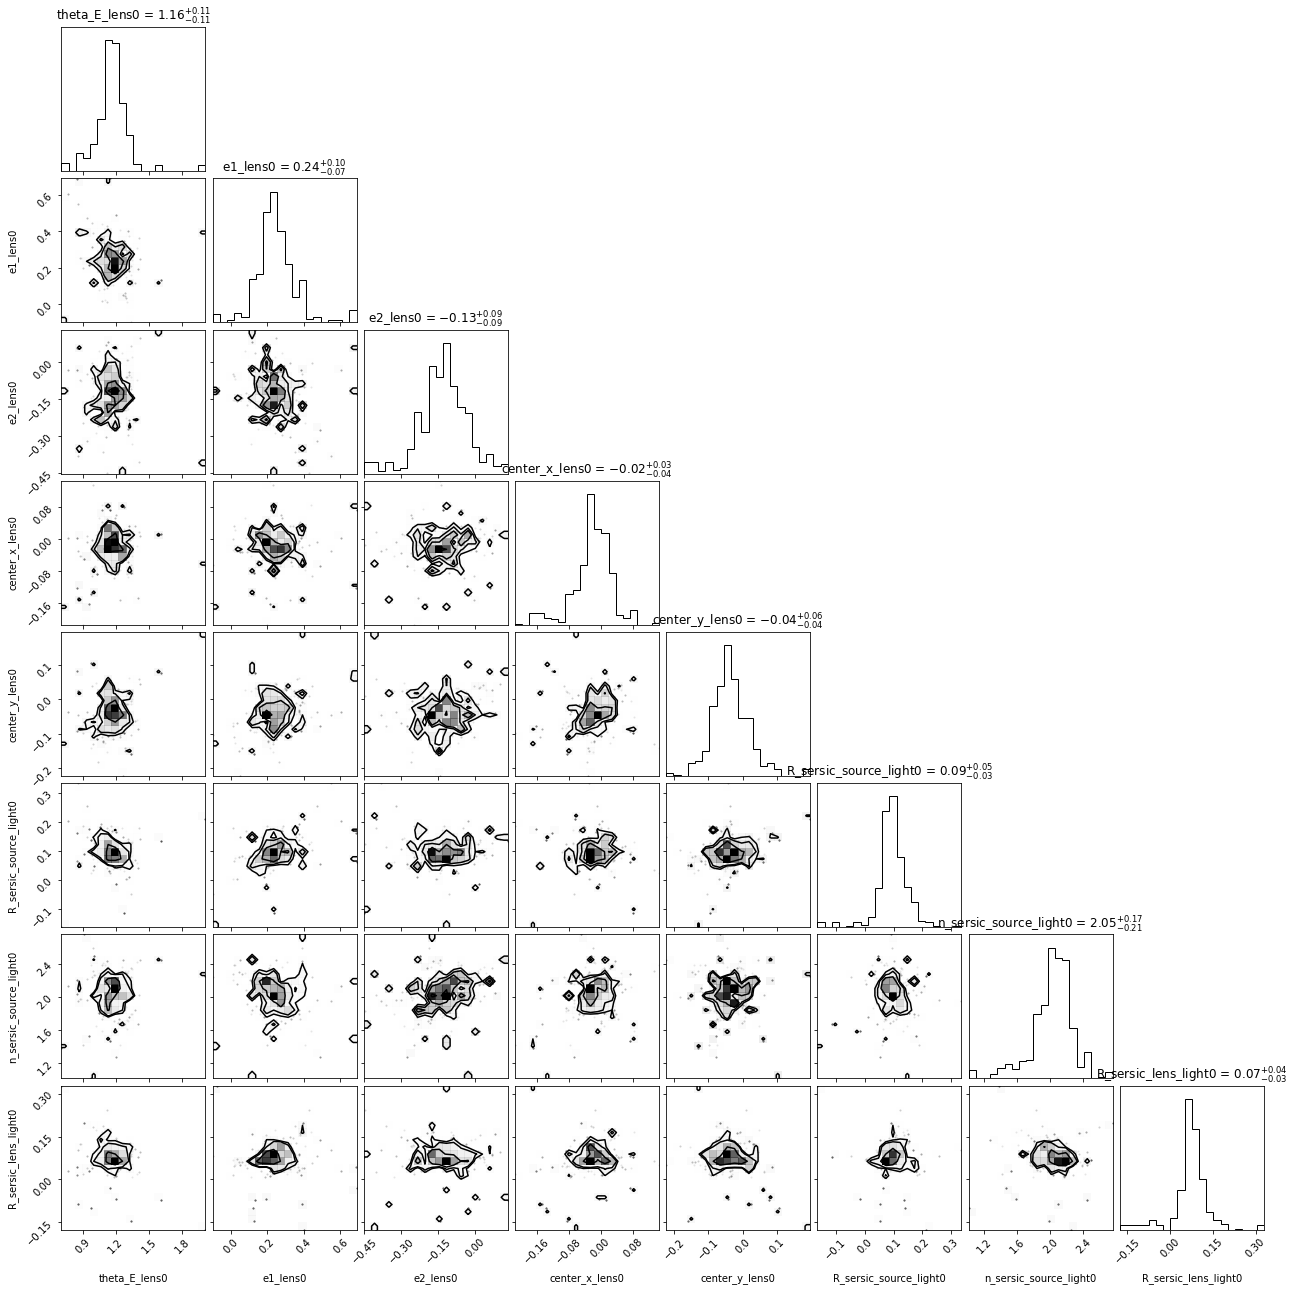

In [24]:
sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[1]
    
print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])
import corner

n, num_param = np.shape(samples_mcmc)
plot = corner.corner(samples_mcmc[:,:8], labels=param_mcmc[:8], show_titles=True)